In [1]:
using Random
using LinearAlgebra
using FMMProject
using Plots
import FMMProject: Laplace2D

In [4]:
# Parameters
Random.seed!(1)
K = Laplace2D   # kernel
N = 2^18
Ntest = 256      # number of test points

points = rand(Point2D,N)
qcharges = randn(N)
qcharges /= norm(qcharges,1)  # normalize charges
idxs  = rand(1:N,Ntest)

# true potential
loopstats = @timed [sum(K(points[i],y)*qy for (y,qy) in zip(points,qcharges)) for i in idxs]
pot = loopstats.value
looptime = loopstats.time / Ntest * N  # approximate total forward map time

21302.428376064

In [5]:
# FMM parameters
Plist = 2:2:20             # interaction rank
b0 = 128 / minimum(Plist)  # average number of points per box / P

64.0

In [6]:
errlist = []   # relative errors
tfmm = []      # time FMM 

for P in Plist
    println("P = $P")
    b = b0*P    # average number of points per box 
    L = max(floor(Int64,log(4,N/b)+1),2)  # number of levels in tree
    # assemble FMM
    fmm = FMMLaplace2D(points,P,L);
    # compute fmm potential and error
    fmmstats = @timed fmm*qcharges
    fmmtime = fmmstats.time
    push!(tfmm,fmmtime)
    pot_approx = fmmstats.value
    pot_test = pot_approx[idxs]
    err = norm(real.(pot_test)-pot,Inf)/norm(pot,Inf)
    push!(errlist,err)
    #@info "" N err looptime fmmtime
end

P = 2
P = 4
P = 6
P = 8
P = 10
P = 12
P = 14
P = 16
P = 18
P = 20


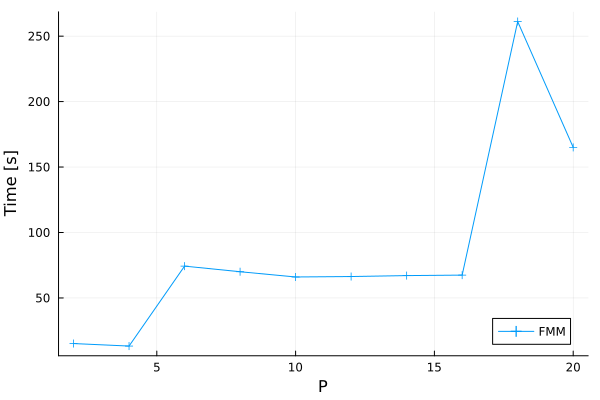

In [7]:
# Plot time
plot(Plist,tfmm,shape=:auto,legend=:bottomright,label="FMM")
#plot!(Plist,tloop,shape=:auto,label="Loop")
#hline!([looptime],label="Loop")
xlabel!("P")
ylabel!("Time [s]")


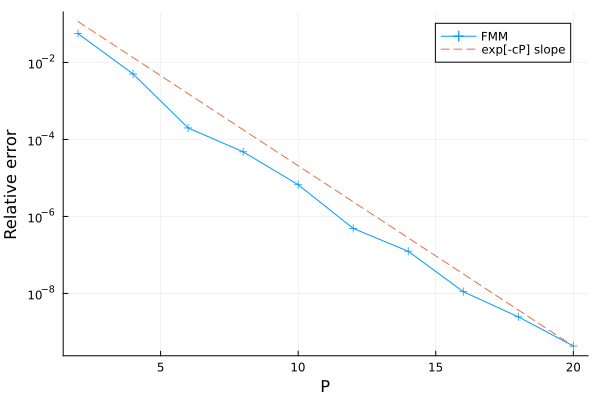

In [8]:
# Plot errors
plot(Plist,errlist,yscale=:log10,shape=:auto,legend=true,label="FMM")
xlabel!("P")
ylabel!("Relative error")

a = -log(errlist[end])/Plist[end]
expp_slope = @. exp(-a*Plist)
expp_slope *= errlist[end]/expp_slope[end]
plot!(Plist,expp_slope,style=:dash,label="exp[-cP] slope")

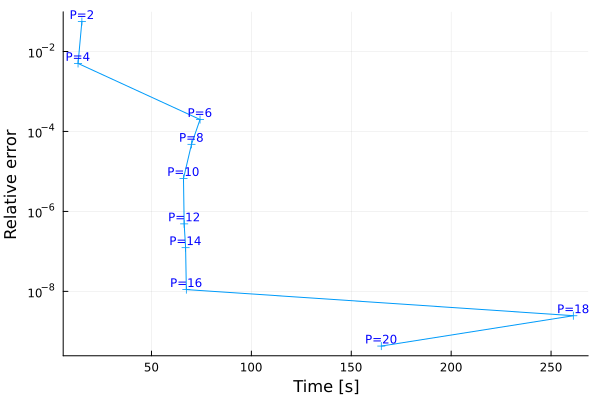

In [17]:
# plot time vs rel. error 
plot(tfmm,errlist,yscale=:log10,shape=:auto,legend=false)
ylabel!("Relative error")
xlabel!("Time [s]")
annotate!(tfmm, errlist, [text("P=$p",8,:bottom,:blue) for p in Plist])
